<a href="https://colab.research.google.com/github/team-signpin/signpin/blob/main/Online_Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import json
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [48]:
import os

# [x[0] for x in os.walk("./")]
#for x in next(os.walk('./drive/MyDrive/Work/Thesis/MOBISIG/USER1'))[2]:
# print(x)

In [49]:
import pandas as pd
signature1 = pd.read_csv('/content/drive/MyDrive/Work/Thesis/MOBISIG/USER1/SIGN_FOR_USER1_USER2_2.csv')
signature1.head()

,x,y,timestamp,pressure,fingerarea,velocityx,velocityy,accelx,accely,accelz,gyrox,gyroy,gyroz
0,419.34134,564.96450,9013372,0.7125,0.127660,0.000000,0.000000,-0.002936,-0.025108,-0.046257,0.0,0.0,0.0
1,419.34134,564.96450,9013396,0.7250,0.127660,0.029627,0.037344,-0.002936,-0.025108,-0.046257,0.0,0.0,0.0
2,419.34134,564.96450,9013429,0.7125,0.085106,0.022956,0.029352,-0.002936,-0.025108,-0.046257,0.0,0.0,0.0
3,425.52330,525.40370,9013446,0.7000,0.117021,276.981260,-1857.441900,-0.002936,-0.025108,-0.046257,0.0,0.0,0.0
4,436.22290,480.65332,9013463,0.6750,0.074468,606.211850,-3012.173300,-0.002936,-0.025108,-0.046257,0.0,0.0,0.0


In [50]:
s1_coords = signature1.iloc[:,:2]
s1_coords

,x,y
0,419.34134,564.96450
1,419.34134,564.96450
2,419.34134,564.96450
3,425.52330,525.40370
4,436.22290,480.65332
...,...,...
141,927.80164,469.99194
142,950.91940,444.88843
143,972.65660,426.43884
144,979.65894,420.13843


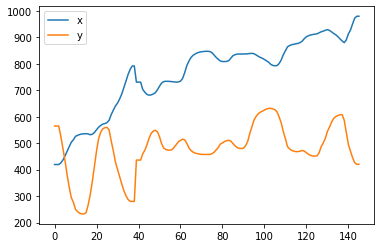

In [51]:
s1_coords.plot()

## Fetch all signatures related to a single user



In [52]:
# list of all users files
from os import listdir
user_list = listdir("./drive/MyDrive/Work/Thesis/MOBISIG")
user_list = user_list[2:] # removes stats and users file
user_list = [int(x[4:]) for x in user_list]
user_list.sort()
user_list = ["USER" + str(x) for x in user_list]
user_list[:5]

['USER1', 'USER2', 'USER3', 'USER4', 'USER5']

## Fetch all signatures related to a single user

In [53]:
# fetch all file names of user_id
def all_files_related_to(user_id):
  user_list = listdir("./drive/MyDrive/Work/Thesis/MOBISIG/USER" + str(user_id) + "/")
  return user_list

all_files_related_to(1)[:5]

['SIGN_GEN_USER1_USER1_26.csv',
 'SIGN_FOR_USER1_USER4_20.csv',
 'SIGN_GEN_USER1_USER1_40.csv',
 'SIGN_GEN_USER1_USER1_36.csv',
 'SIGN_GEN_USER1_USER1_11.csv']

## Fetched all the original signatures

In [54]:
# array of original signatures
user_id = 1
orig_sigs = []
for i in range(1, 46):
  sig_data = pd.read_csv(f"/content/drive/MyDrive/Work/Thesis/MOBISIG/USER1/SIGN_GEN_USER{user_id}_USER{user_id}_" + str(i) +'.csv')
  sig_data = sig_data.iloc[:, :3]
  orig_sigs.append(sig_data)

# pd.read_csv('/content/drive/MyDrive/Work/Thesis/MOBISIG/USER1/SIGN_GEN_USER1_USER1_1.csv')
print("Shape of a signature", orig_sigs[0].shape)

Shape of a signature (147, 3)


## Normalized the signature into fixed number of data points

shape of a signature (90, 5)


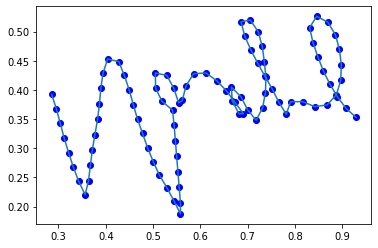

In [55]:
import math
def distance(p1, p2):
  return math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )


def midDistance(data, n):
  dis = data[:, 3]
  given_di = n
  end_point = np.searchsorted(dis, given_di)
  end_point_vdi = data[end_point, 3]
  start_point_vdi = data[end_point - 1, 3]
  start_d_point = data[end_point-1];
  end_d_point = data[end_point]
  div = (given_di - start_point_vdi) / (end_point_vdi - start_point_vdi)

  new_point_x = (end_d_point[0] - start_d_point[0])*div + start_d_point[0]
  new_point_y = (end_d_point[1] - start_d_point[1])*div + start_d_point[1]
  
  new_point = [new_point_x, new_point_y, start_d_point[2], start_d_point[3], given_di]
  new_point = [round(x, 5) for x in new_point]
  return new_point

def cumulativeDistance(data):
  # FIXME more accurate, print to see the issue in the beginning and ending
  data = np.pad(data, ((0, 0), (0, 1)), mode='constant', constant_values=0)
  c_data = data
  sum = 0
  for i in range(0, len(data) -1):
    c_data[i][3] = sum
    next_point = [c_data[i+1][0], c_data[i+1][1]]
    current_point = [c_data[i][0], c_data[i][1]]
    sum += distance(current_point, next_point)
  return c_data


def normalizeByDistance(data, n):
  c_data = cumulativeDistance(data)
  # print("c_data", c_data.shape)
  total_distance = c_data[-2][3]
  # print(f'total distance: {total_distance}')
  return np.array([ midDistance(c_data, (total_distance/n) * x) for x in range(1,n)])


def normalizeSign(orig_sig):
  tmp_np = np.array(orig_sig)
  tmp_normalized = normalizeByDistance(tmp_np, 91)
  tmp_normalized = tmp_normalized.astype(np.float32)
  return tmp_normalized / 1200


tmp = normalizeSign(orig_sigs[0])
plt.plot(tmp[:,0], tmp[:,1], "bo")
plt.plot(tmp[:,0], tmp[:,1])
print("shape of a signature", tmp.shape)

## Fetch forged signatures

In [56]:
# List all signature files of a user
from os import listdir
user_sign_path = "./drive/MyDrive/Work/Thesis/MOBISIG/USER" + str(user_id)
sign_list = listdir(user_sign_path)
sig_data_dict = {}
for sign in sign_list:
  tmp_sig_data = pd.read_csv(f"{user_sign_path}/{sign}")
  sig_data_dict[sign] = tmp_sig_data.iloc[:, :3]

len(sig_data_dict)

65

In [57]:
# Normalize and label
normalized_signs_dict = {}
for key, value in sig_data_dict.items():
  # print(key[5:8], value.shape)
  try:
    normalized_signs_dict[key] = normalizeSign(value)
  except IndexError as e:
    print(key, e)


len(normalized_signs_dict)

SIGN_FOR_USER1_USER3_10.csv index 223 is out of bounds for axis 0 with size 223
SIGN_GEN_USER1_USER1_8.csv index 126 is out of bounds for axis 0 with size 126


63

(90, 4)

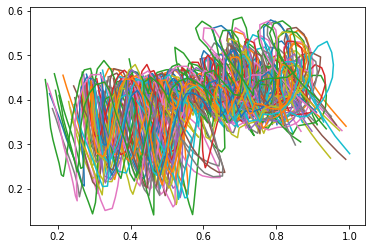

In [58]:
# trying to plot a normalized sign


# tmp = normalized_signs[3]
last = []
for key, tmp in normalized_signs_dict.items():
  # plt.plot(tmp[:,0], tmp[:,1], "bo")
  tmp = tmp[:,:4]
  last = tmp
  try:
    plt.plot(tmp[:,0], tmp[:,1])
  except TypeError as e:
    print(e)

len(last)
last.shape

Reshaped

In [59]:
# Reshaped

reshaped_signs_dict = {}

for key, value in normalized_signs_dict.items():
  # tmp = value[:, :3]
  reshaped_signs_dict[key] = tmp #.reshape(90*3)

reshaped_signs_dict.keys()
list(reshaped_signs_dict.values())[0].shape, len(reshaped_signs_dict)

((90, 4), 63)

## Preparing labels

In [60]:
# Preparing labels

tmp_labels = reshaped_signs_dict.keys()
tmp_labels = list(tmp_labels)
labels = []

for label in tmp_labels:
  if label[5:8] == "FOR":
    labels.append(np.array([0]))
  elif label[5:8] == "GEN":
    labels.append(np.array([1]))

len(labels)

63

## Created a table like the following


| signature dataframe | label | means |
| --- | --- | :-: |
| SIG[] | 0 | FORGED |
| SIG[] | 1 | ORIGINAL |
| SIG[] | 0 | FORGED |
| SIG[] | 0 | FORGED |

Here signature dataframe is a matrix of a single signature attempt.

Original Signatures: **45**<br/>
Forge attempts: **18**

## Creating models
### ANN model

In [61]:
import tensorflow as tf


# Creating model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(270,)))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.softmax))

# We will now compile and print out a summary of our model
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               69376     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 69,633
Trainable params: 69,633
Non-trainable params: 0
_________________________________________________________________


### CNN Model

In [62]:
import tensorflow as tf


# Creating model
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(256, (2,2), activation=tf.nn.relu, input_shape=(90, 4,1)))
# cnn_model.add(tf.keras.layers.Dense(1, activation=tf.nn.softmax))

# We will now compile and print out a summary of our model
cnn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])


## Split train and test

Total data of a user:

Original signature: **45** <br/>
Forged signature: **18**


70% originial signature: **31** <br/>
50% forged signature: **9**

60% of 63: **37**

In [63]:
tmp = list(reshaped_signs_dict.values())
X_train, label_train = (tmp[:37], labels[:37])
X_test, label_test = (tmp[37:], labels[37:])
X_train = np.array(X_train).astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
X_test = X_test.astype(np.float32)
label_train = np.array(label_train)
# label_train = tf.keras.utils.to_categorical(label_train, 0)

X_train.shape, label_train.shape, len(X_test), len(label_test), 

((37, 90, 4), (37, 1), 26, 26)

## SVM Model training

In [64]:
from sklearn import svm
clf = svm.SVC()
label_train_svm = label_train.reshape(37)
X_train = X_train.reshape(37, 90*4)
print(X_train.shape, label_train_svm.shape)
clf.fit(X_train, label_train_svm)


(37, 360) (37,)


SVC()

In [65]:
X_test_svm = X_test.reshape(26, 90*4)
clf.predict(X_test_svm)
# print(X_test.shape)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

## Training

In [68]:
# X_train = X_train.astype(np.float32)

print(type(X_train[0][0]), type(label_train))
print(len(X_train))
print(len(label_train))

# reshape for CNN model
print("Shape", X_train.shape)
# X_train_c = tf.expand_dims(X_train, axis=-1)
# X_test_c = X_test.reshape(len(X_test), 90, 3, 1)
model.fit(X_train, np.array(label_train), epochs=2)

<class 'numpy.float32'> <class 'numpy.ndarray'>
37
37
Shape (37, 360)
Epoch 1/2


ValueError: ignored

## Evaluate performance


In [ ]:
loss, accuracy = model.evaluate(X_test, np.array(label_test))
print('Test accuracy: %.2f' % (accuracy))

In [ ]:
plt.plot(orig_sigs[0].iloc[:, 0], orig_sigs[0].iloc[:, 1], 'ro')

In [ ]:
for orig_sig in orig_sigs:
  plt.plot(orig_sig.iloc[:,0], orig_sig.iloc[:,1])
  print(len(orig_sig))

# plt.plot(sig_to_vis.iloc[:,0], sig_to_vis.iloc[:,1])
# plt.plot(sig_to_vis1.iloc[:,0], sig_to_vis1.iloc[:,1])

In [ ]:
import tensorflow as tf